In [172]:
# Import library
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [173]:
# Get data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print('train:'+str(train.shape))
print('test:'+str(test.shape))

train:(1460, 81)
test:(1459, 80)


In [174]:
# Check for Id duplicates
idsUnique = len(set(train.Id)) #set创建一个无序不重复序列
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print('There are ' + str(idsDupli) + ' duplicate IDs for ' + str(idsTotal) 
      + ' total entries')

# Drop Id column
train.drop('Id', axis=1, inplace=True)

There are 0 duplicate IDs for 1460 total entries


In [175]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [176]:
# Data understanding
print(train['SalePrice'].describe())

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64


Skewness: 1.882876
Kurtosis: 6.536282


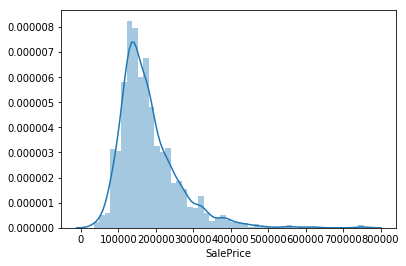

In [177]:
# Using histogram to have a big picture of the overall house price distribution
sns.distplot(train['SalePrice'])

# skewness and kurtosis 偏度和峰值
print('Skewness: %f' % train['SalePrice'].skew()) #偏度为正，说明数据集中在左边
print('Kurtosis: %f' % train['SalePrice'].kurt()) #峰值为0，说明正态分布

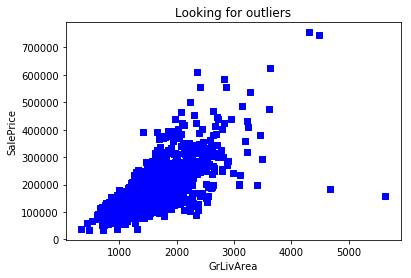

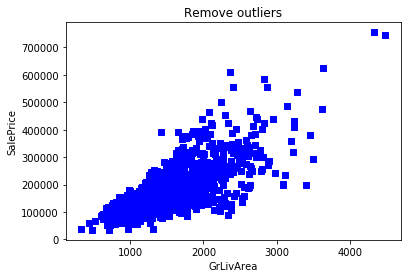

In [178]:
# Numerical features
# Scatter plot GrliveArea (Above grade (ground) living area square feet) and SalePrice
plt.scatter(train['GrLivArea'], train['SalePrice'], c='blue', marker='s')
plt.title('Looking for outliers')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

# Deleting points
train.sort_values(by='GrLivArea', ascending=False).head()[0:2]
train = train.drop(523)
train = train.drop(1298)

# Scatter plot for removing outliers
plt.scatter(train['GrLivArea'], train['SalePrice'], c='blue', marker='s')
plt.title('Remove outliers')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [179]:
# log transform the target for official scoring
# 在数据预处理的时候可以对偏度比较大的数据用log1p函数进行转化，使其更加服从高斯分布
# 此步处理可能会对我们后续的分类得到一个更好的结果
# log1p 即 ln(x+1)
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

In [180]:
train_desc = pd.DataFrame(train.describe().T)
train_desc
train_desc.loc[train_desc['count']!=1458]

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1199.000,69.797,23.203,21.000,59.000,69.000,80.000,313.000
MasVnrArea,1450.000,102.754,179.442,0.000,0.000,0.000,164.750,1600.000
GarageYrBlt,1377.000,1978.464,24.683,1900.000,1961.000,1980.000,2002.000,2010.000


In [181]:
train.loc[:,'LotFrontage'] = train.loc[:,'LotFrontage'].fillna(0)
train.loc[:,'MasVnrArea'] = train.loc[:,'MasVnrArea'].fillna(0)
#train.loc[:,'GarageYrBlt'] = train.loc[:,'GarageYrBlt']

In [192]:
# check Alley NA total qty and fill NA with 'None', means 'no alley access'
train[train.loc[:,'Alley'].isnull()].shape
train.loc[:,'Alley'] = train.loc[:,'Alley'].fillna('None')
# fill NA with 'No', means 'no basement'
train.loc[:,'BsmtQual'] = train.loc[:,'BsmtQual'].fillna('No')
train.loc[:,'BsmtCond'] = train.loc[:,'BsmtCond'].fillna('No')
train.loc[:,'BsmtExposure'] = train.loc[:,'BsmtExposure'].fillna('No')
train.loc[:,'BsmtFinType1'] = train.loc[:,'BsmtFinType1'].fillna('No')
train.loc[:,'BsmtFinType2'] = train.loc[:,'BsmtFinType1'].fillna('No')
# fill NA with 'No', means 'no fence'
train.loc[:,'Fence'] = train.loc[:,'Fence'].fillna('No')
# fill NA with 'No', means 'no fireplace'
train.loc[:,'FireplaceQu'] = train.loc[:'FireplaceQu'].fillna('No')
# fill NA with 'No', means 'no garage'
train.loc[:,'GarageType'] = train.loc[:,'GarageType'].fillna('No')
train.loc[:,'GarageFinish'] = train.loc[:,'GarageFinish'].fillna('No')
train.loc[:,'GarageQual'] = train.loc[:,'GarageQual'].fillna('No')
train.loc[:,'GarageCond'] = train.loc[:,'GarageCond'].fillna('No')


train[train.loc[:,'GarageCars'].isnull()].shape

(0, 80)

In [76]:
corr = corr.sort_values(['SalePrice'], ascending=False)
corr.SalePrice

SalePrice        1.000
OverallQual      0.821
GrLivArea        0.725
GarageCars       0.681
GarageArea       0.656
TotalBsmtSF      0.648
1stFlrSF         0.621
FullBath         0.596
YearBuilt        0.587
YearRemodAdd     0.566
GarageYrBlt      0.542
TotRmsAbvGrd     0.538
Fireplaces       0.492
MasVnrArea       0.431
BsmtFinSF1       0.392
WoodDeckSF       0.334
OpenPorchSF      0.325
2ndFlrSF         0.320
HalfBath         0.314
LotArea          0.261
BsmtFullBath     0.237
BsmtUnfSF        0.222
BedroomAbvGr     0.209
LotFrontage      0.183
ScreenPorch      0.121
PoolArea         0.074
MoSold           0.057
3SsnPorch        0.055
BsmtFinSF2       0.005
BsmtHalfBath    -0.005
MiscVal         -0.020
OverallCond     -0.037
YrSold          -0.037
LowQualFinSF    -0.038
MSSubClass      -0.074
KitchenAbvGr    -0.148
EnclosedPorch   -0.149
Name: SalePrice, dtype: float64

In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape)
print(df_test.shape)

In [ ]:
df_train.columns

In [ ]:
print(df_train['SalePrice'].describe())

In [ ]:
# Using histogram to have a big picutre of the overall house price distribution
sns.distplot(df_train['SalePrice'])

# skewness and kurtosis 偏度和峰值
print('Skewness: %f' % df_train['SalePrice'].skew()) #偏度为正，说明数据集中在左边
print('Kurtosis: %f' % df_train['SalePrice'].kurt()) #峰值为0，说明正态分布

In [ ]:
# numerical features
# Scatter plot GrLiveArea (Above grade (ground) living area square feet) and SalePrice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]],axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [ ]:
# Numerical features
# Scatter plot TotalBsmtSF (Total square feet of basement area) and SalePrice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]],axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [ ]:
# Categorical features
# Box plot OverallQual (Overall material and finish quality) and SalePrice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train['OverallQual']],axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)

In [ ]:
# Categorial features
# Box plot YearBuilt and SalePrice
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16,8))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
plt.xticks(rotation=90)
fig.axis(ymin=0, ymax=800000)

In [ ]:
# Correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.8, square=True)

In [ ]:
# Saleprice correlation matrix

k = 10 #number of variables for heatmap

# select 10 largest correlation variables to Saleprice
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index 
print(cols)
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, fmt='0.2f', annot_kws={'size':10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()


In [ ]:
# Scatter plots between the most correalted variables
cols = ['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt']
sns.pairplot(df_train[cols], size=2.5)
plt.show()

In [ ]:
# find out missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data.head(20)

In [ ]:
# Dealing with missing data
df_train = df_train.drop(missing_data[missing_data['Total']>1].index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

# Double check to confirm there is no missing data
df_train.isnull().sum().max()

In [ ]:
# Standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis])
low_range =  saleprice_scaled[saleprice_scaled[:,0].argsort()][:10] #argsort: output is index for value ascending
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('outer range (high) of the distribution:')
print(high_range)

In [ ]:
# Bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]],1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [ ]:
# Deleting points
df_train.sort_values(by='GrLivArea',ascending=False).head()[0:2]
df_train = df_train.drop(df_train[df_train['Id']==1299].index)
df_train = df_train.drop(df_train[df_train['Id']==524].index)

# Make sure these 2 row has been deleted
df_train.plot.scatter(x='GrLivArea', y='SalePrice',ylim=(0,800000))

In [ ]:
# Bivariate analysis saleprice/TotalbsmtSF
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']],axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [ ]:
# histogram and normal probability plot
sns.distplot(df_train['SalePrice'],fit=norm)
fig=plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)